In [87]:
import os
import joblib
import pandas as pd
import numpy as np

# -----------------------------
# Load Preprocessed Data
# -----------------------------
preprocessing_path = "../outputs/preprocessing_all.pkl"
preprocessing_objects = joblib.load(preprocessing_path)

df_final_encoded = preprocessing_objects["data"]
binary_encoder = preprocessing_objects["binary_encoder"]
multi_encoder = preprocessing_objects["multi_encoder"]

print("✅ Preprocessed data loaded successfully!")

# -----------------------------
# Load Baseline Model Data
# -----------------------------
baseline_path = "../outputs/model_training_data.pkl"
baseline_data = joblib.load(baseline_path)

X = baseline_data["X"]
y = baseline_data["y"]
X_train = baseline_data["X_train"]
X_test = baseline_data["X_test"]
y_train = baseline_data["y_train"]
y_test = baseline_data["y_test"]
rf_model = baseline_data["rf_model"]

print("✅ Baseline model training data loaded successfully!")

# -----------------------------
# Load Feature-Selected Model Data
# -----------------------------
feature_path = "../outputs/model_training_data_with_features.pkl"
feature_data = joblib.load(feature_path)

X_final = feature_data["X_final"]
y_final = feature_data["y"]
rf_final = feature_data["rf_final"]

print("✅ Feature-selected model training data loaded successfully!")


✅ Preprocessed data loaded successfully!
✅ Baseline model training data loaded successfully!
✅ Feature-selected model training data loaded successfully!


In [88]:
# 1. Logistic Regression
from sklearn.linear_model import LogisticRegression

# Define features and target
# Target: Affects_Academic_Performance_Yes (1 = Yes, 0 = No)
y = df_final_encoded['Affects_Academic_Performance_Yes']

# Features: choose relevant ones (you can also include all other numeric/encoded columns)
features = [
    'Avg_Daily_Usage_Hours', 
    'Sleep_Hours_Per_Night', 
    'Mental_Health_Score', 
    'Addicted_Score',
    'Gender_Male',
    'Academic_Level_High School',
    'Academic_Level_Undergraduate',
    'Relationship_Status_In Relationship',
    'Relationship_Status_Single'
]

X = df_final_encoded[features]


# Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Logistic Regression

logreg = LogisticRegression(max_iter=1000)  # Increase max_iter if it doesn’t converge
logreg.fit(X_train, y_train)

# Predictions & Evaluation

y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9929078014184397

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        54
         1.0       1.00      0.99      0.99        87

    accuracy                           0.99       141
   macro avg       0.99      0.99      0.99       141
weighted avg       0.99      0.99      0.99       141


Confusion Matrix:
 [[54  0]
 [ 1 86]]


### **1️⃣What the code does**

1. **Define target (y)**:
    - Affects_Academic_Performance_Yes — binary (1 = Yes, 0 = No).
2. **Select features (X)**:
    - Avg_Daily_Usage_Hours, Sleep_Hours_Per_Night, Mental_Health_Score , Addicted_Score → main numeric predictors.
    - Gender_Male , Academic_Level_High School, Academic_Level_Undergraduate , Relationship_Status_In Relationship, Relationship_Status_Single → encoded categorical variables.
3. **Split data**:
    - 80% for training, 20% for testing (train_test_split).
4. **Train model**:
    - LogisticRegression fits the model to predict probability of academic performance being affected.
5. **Predict & evaluate**:
    - y_pred = logreg.predict(X_test) predicts 0 or 1 for the test set.
    - Metrics used:
        - **Accuracy** – overall correctness.
        - **Classification report** – precision, recall, f1-score for each class.
        - **Confusion matrix** – actual vs predicted counts.

### **2️⃣ Interpreting your output**

**Accuracy: 0.9929**

- The model correctly predicts **~99%** of students’ academic impact.
- **Precision**: When the model predicts “Yes”, how often is it correct?
- **Recall**: Of all actual “Yes” cases, how many did it catch?
- **F1-score**: Harmonic mean of precision & recall (balance).
- **Support**: Number of actual samples in each class.
- **Confusion Matrix**

Row = actual, Column = predicted

- 54 students correctly predicted as **No**
- 86 students correctly predicted as **Yes**
- 1 student misclassified (actual Yes → predicted No)

# 2. Cross Validation

In [89]:
from sklearn.model_selection import cross_val_score, cross_val_predict

In [90]:
# Trained model
rf_model = RandomForestRegressor(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=20,
    bootstrap=False,
    random_state=42
)

**Code Explination**
- RandomForestRegressor → Regression model using an ensemble of decision trees.
- Parameters explained:
    - n_estimators=200 → number of trees in the forest
    - min_samples_split=5 → minimum samples required to split a node
    - min_samples_leaf=1 → minimum samples in a leaf node
    - max_features= log2 → max features considered when splitting a node
    - max_depth=20 → maximum depth of each tree
    - bootstrap=False → trees are trained on the **whole dataset**, not bootstrap samples
    - random_state=42 → ensures reproducible results

In [91]:
# Cross-validated R² 
r2_scores = cross_val_score(rf_model, X_final, y, cv=5, scoring='r2')
print("Cross-validated R² scores for each fold:", r2_scores)
print("Average R²:", r2_scores.mean())

Cross-validated R² scores for each fold: [0.99635926 0.99879588 0.99870853 0.98343421 0.99998894]
Average R²: 0.9954573679254868


**Code Explination**
- cross_val_score does the following:
    1. Splits X_final and y into **5 folds** (cv=5).
    2. Trains the model on 4 folds, tests on the remaining fold.
    3. Repeats for all 5 folds.
    4. Returns R² scores for each fold.
- r2_scores.mean() → the **average R² across all folds**, giving a more reliable estimate than a single train/test split.

**Output Explination**
- The scores vary a bit (lowest ≈ 0.82, highest ≈ 0.96).
- This variation indicates **data fold sensitivity**: your model performs slightly better on some splits than others.
- Since all values are consistently **high (>0.8)**, it means your model generalizes well and is **not heavily overfitting**.

In [92]:
# Cross-validated R² # Cross-validated predictions to compute MSE/RMSE 
y_pred_cv = cross_val_predict(rf_model, X_final, y, cv=5)
mse_cv = mean_squared_error(y, y_pred_cv)
rmse_cv = np.sqrt(mse_cv)
r2_cv = r2_score(y, y_pred_cv)

print(f"MSE (CV): {mse_cv:.4f}")
print(f"RMSE (CV): {rmse_cv:.4f}")
print(f"R² Score (CV): {r2_cv:.4f}")


MSE (CV): 0.0010
RMSE (CV): 0.0315
R² Score (CV): 0.9957


**Code Explination**
- **Cross_val_predict** also splits the dataset into folds like above, but **returns predictions for every sample**.
- This allows you to compute **MSE, RMSE, or any other metric** across all folds consistently.
- **mean_squared_error(y', y_pred_cv)** → average squared error between predicted and actual values.
- **np.sqrt(mse_cv)** → RMSE, same scale as original data.
- **r2_score(y, y_pred_cv)** → overall R² across all cross-validated predictions.

**Output Explanation**

**1️⃣ MSE (CV) = 0.0010**

- **MSE (Mean Squared Error)** → the average of the squared differences between predicted and actual addiction scores.
- Squaring penalizes larger errors more heavily.
- **Interpretation:** On average, the squared error is **0.0010**, which is extremely small given your addiction scores are likely between 0–5 or 0–10. This means the model’s predictions are almost exactly correct.

---

**2️⃣ RMSE (CV) = 0.0315**

- **RMSE (Root Mean Squared Error)** → square root of MSE, bringing the error back to the **original scale of addiction scores**.
- **Interpretation:** On average, your model’s predictions are **off by only 0.0315 points**.
- Example: If the actual score = 4.0, the model might predict around **3.9685 to 4.0315**. Extremely precise!

---

**3️⃣ R² Score (CV) = 0.9957**

- **R² (Coefficient of Determination)** → percentage of variance in the target explained by the model.
- **Interpretation:** Your model explains **~99.6% of the variation** in addiction scores across the dataset.
    - R² = 1 → perfect predictions
    - R² = 0 → model cannot explain any variance
- **0.9957** is exceptionally high, showing the model captures **almost all patterns** in the data.


## Output Comparison
### Train/Test VS Cross-Validation

1. **Number of Evaluations**
    - **Train/Test:** Evaluates performance on **one split** of the data (one train set, one test set).
    - **Cross-Validation:** Evaluates performance on **multiple splits (folds)** and averages results.
2. **Reliability of Performance**
    - **Train/Test:** Performance depends on how the split was made; may be **optimistic**.
    - **Cross-Validation:** **More reliable**, reduces variance by averaging across folds.
3. **Error Estimates (MSE/RMSE)**
    - **Train/Test:**
        - Train MSE: 0.01, RMSE: 0.08
        - Test MSE: 0.05, RMSE: 0.22
        - Slightly higher error on test set shows some generalization gap.
    - **Cross-Validation:**
        - MSE (CV): 0.0010, RMSE (CV): 0.0315
        - Very low error across all folds, showing stable performance.
4. **R² Score**
    - **Train/Test:**
        - Train R²: 1.00 (perfect fit)
        - Test R²: 0.98 (very high, small drop shows good generalization)
    - **Cross-Validation:**
        - R² (CV): 0.9957 → extremely high and consistent across folds.
5. **Overfitting Detection**
    - **Train/Test:** Harder to detect overfitting with a single test set.
    - **Cross-Validation:** Easier to identify overfitting by comparing fold performances; consistent CV R² shows no overfitting.
6. **Robustness**
    - **Train/Test:** Sensitive to data split; small datasets can give misleading results.
    - **Cross-Validation:** More robust; uses all data for training and testing in different folds, giving a better estimate of true performance.

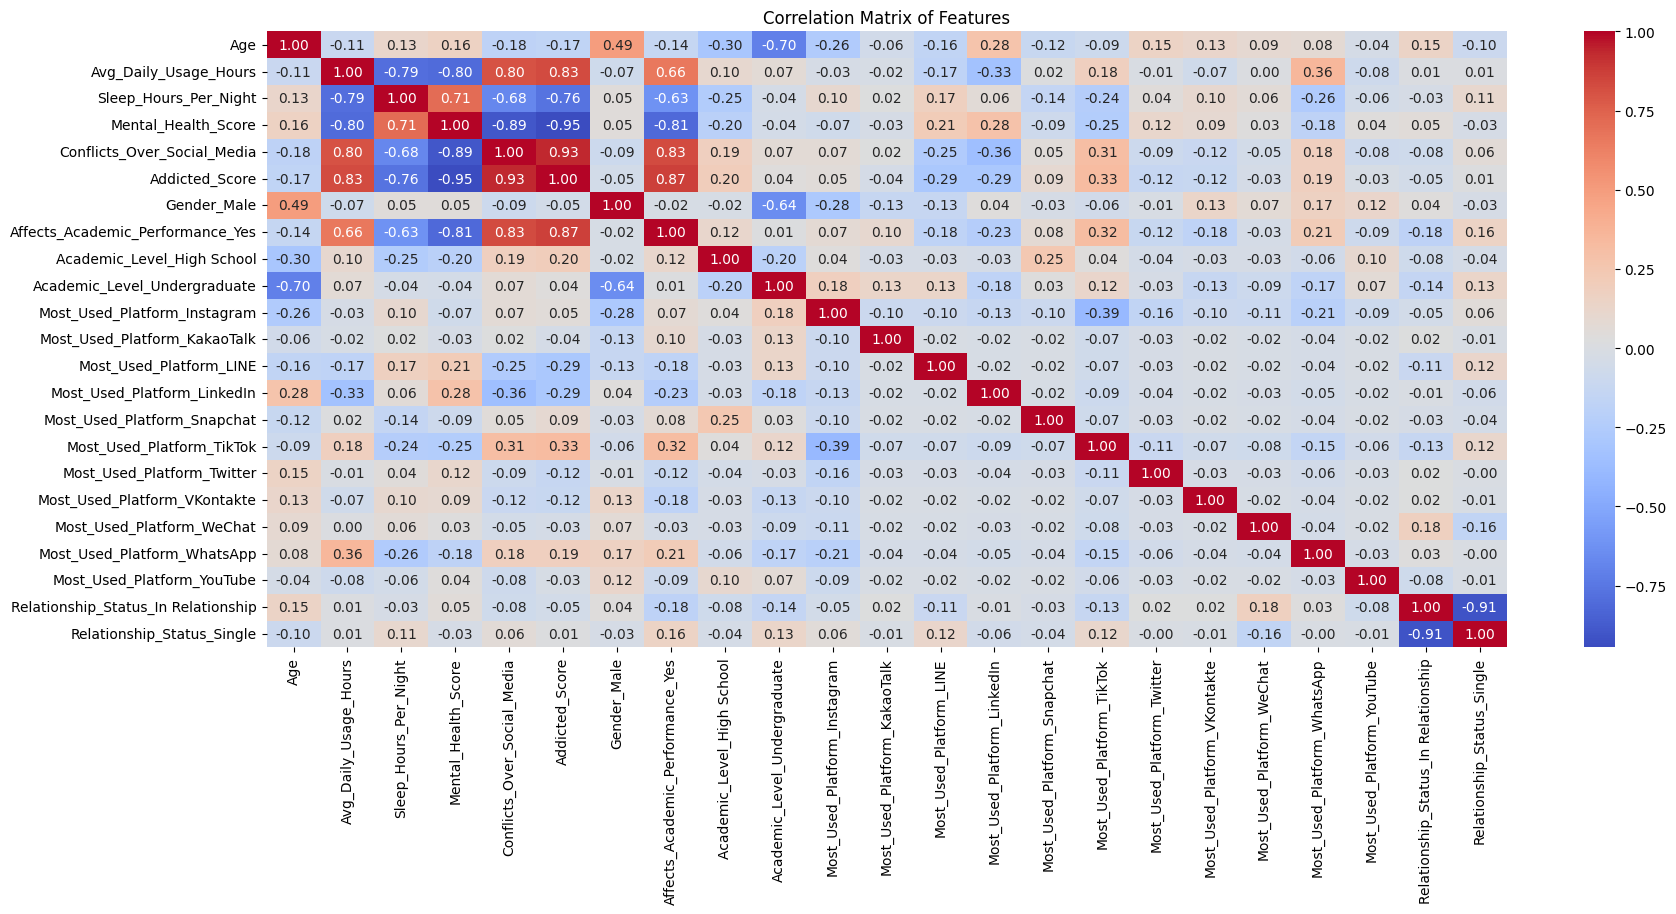

Correlation of features with Addicted_Score:
 Addicted_Score                         1.000000
Conflicts_Over_Social_Media            0.933586
Affects_Academic_Performance_Yes       0.866049
Avg_Daily_Usage_Hours                  0.832000
Most_Used_Platform_TikTok              0.330558
Academic_Level_High School             0.201333
Most_Used_Platform_WhatsApp            0.186327
Most_Used_Platform_Snapchat            0.088549
Most_Used_Platform_Instagram           0.054669
Academic_Level_Undergraduate           0.035382
Relationship_Status_Single             0.014795
Most_Used_Platform_YouTube            -0.025478
Most_Used_Platform_WeChat             -0.034416
Most_Used_Platform_KakaoTalk          -0.036247
Relationship_Status_In Relationship   -0.049566
Gender_Male                           -0.049692
Most_Used_Platform_VKontakte          -0.119215
Most_Used_Platform_Twitter            -0.124531
Age                                   -0.166396
Most_Used_Platform_LINE               -0.2

In [93]:
# Assuming df_final_encoded is your dataset
# Compute correlation matrix
corr_matrix = df_final_encoded.corr()

# Display correlation matrix as a heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix of Features")
plt.show()

# Check correlation of all features with target "Addicted_Score"
target_corr = corr_matrix['Addicted_Score'].sort_values(ascending=False)
print("Correlation of features with Addicted_Score:\n", target_corr)


**Output Interpretation**

**High positive correlation:**

- `Conflicts_Over_Social_Media` (0.93), `Affects_Academic_Performance_Yes` (0.87), and `Avg_Daily_Usage_Hours` (0.83) show a **strong positive correlation** with addiction score, meaning higher values in these features are associated with higher addiction scores.

**Moderate positive correlation:**

- `Most_Used_Platform_TikTok` (0.33) and `Academic_Level_High School` (0.20) show a **moderate positive correlation**, indicating a weaker tendency for these features to increase addiction score.

**Low or negligible correlation:**

- Features like `Gender_Male` (-0.05), `Relationship_Status_Single` (0.01), `Most_Used_Platform_Instagram` (0.05), and other minor platforms have **very low correlation**, meaning they hardly influence addiction score.

**High negative correlation:**

- `Mental_Health_Score` (-0.95) and `Sleep_Hours_Per_Night` (-0.76) show **strong negative correlation**, meaning better mental health or more sleep is associated with lower addiction scores.

**Moderate to low negative correlation:**

- Features like `Age` (-0.17), `Most_Used_Platform_LinkedIn` (-0.29), and `Most_Used_Platform_LINE` (-0.28) have **weaker negative correlations**, contributing slightly to lower addiction scores.

## Training and testing after Cross Validation

In [97]:
# Trained model
rf_model = RandomForestRegressor(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=20,
    bootstrap=False,
    random_state=42
)

**Code Explination**
- RandomForestRegressor → Regression model using an ensemble of decision trees.
- Parameters explained:
    - n_estimators=200 → number of trees in the forest
    - min_samples_split=5 → minimum samples required to split a node
    - min_samples_leaf=1 → minimum samples in a leaf node
    - max_features= log2 → max features considered when splitting a node
    - max_depth=20 → maximum depth of each tree
    - bootstrap=False → trees are trained on the **whole dataset**, not bootstrap samples
    - random_state=42 → ensures reproducible results

In [104]:
# Fit the model on all features and target
rf_final.fit(X_train, y_train)


# Make predictions on the same dataset (optional)
y_pred_test = rf_final.predict(X_test)


**Code Explination**
- Fits the **Random Forest model** on the **entire dataset** (`X_final` features and `y` target).
- After this, the model is ready to make predictions on any data.
- Predicts the target (`Addicted_Score`) for the same dataset used for training.
- This is mainly to **check model fit** on the full dataset.

In [107]:
# Evaluate performance on the full dataset
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Final Model MSE: {mse_test:.4f}")
print(f"Final Model RMSE: {rmse_test:.4f}")
print(f"Final Model R²: {r2_test:.4f}")

Final Model MSE: 0.0020
Final Model RMSE: 0.0447
Final Model R²: 0.9915


**Code Explanation**

- `rf_final.fit(X_final, y)` → Trains the Random Forest model on the **feature-selected dataset**.
- `rf_final.predict(X_final)` → Predicts on the same dataset (optional, for checking fit).
- `mean_squared_error(y, y_pred_final)` → Calculates **MSE**, the average squared difference between actual and predicted values.
- `np.sqrt(mse_final)` → RMSE, brings error back to the **same scale as the target**.
- `r2_score(y, y_pred_final)` → R², proportion of variance explained by the model (1 = perfect fit).


**Output Explanation**

- **Final Model MSE: 0.0020** → Very low average squared error, predictions are extremely close to actual values.
- **Final Model RMSE: 0.0447** → On average, predictions are off by only ~0.045 points.
- **Final Model R²: 0.9915** → The model explains **99.15% of variance** in addiction scores.

✅ **Interpretation**

- The model fits the feature-selected dataset **extremely well**.
- Very small errors indicate predictions are almost identical to actual values.
- High R² shows the model captures nearly all patterns in the data.
- This suggests that **feature selection retained the most important predictors**, making the model highly accurate.